In [1]:
from torch.utils.data import Dataset

import stats as sts
import librosa
from tqdm import tqdm
from config.utils import *
import  argparse
import torch
import torchaudio
from  torchaudio import  functional as F
from config.gtg import gen_gamma_3channel, gammatonegram_torch


/home/respecting-god/anaconda3/envs/torch1.7.1/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:

class image_loader(Dataset):
    def __init__(self, data_dir, folds_file, test_fold, train_flag, params_json, input_transform=None, stetho_id=-1,
                 aug_scale=None):

        # getting device-wise information
        self.file_to_device = {}
        device_to_id = {}
        device_id = 0
        files = os.listdir(data_dir)
        device_patient_list = []
        pats = []
        for f in files:
            device = f.strip().split('_')[-1].split('.')[0]
            if device not in device_to_id:
                device_to_id[device] = device_id
                device_id += 1
                device_patient_list.append([])
            self.file_to_device[f.strip().split('.')[0]] = device_to_id[device]
            pat = f.strip().split('_')[0]
            if pat not in device_patient_list[device_to_id[device]]:
                device_patient_list[device_to_id[device]].append(pat)
            if pat not in pats:
                pats.append(pat)

        print("DEVICE DICT", device_to_id)
        for idx in range(device_id):
            print("Device", idx, len(device_patient_list[idx]))

        # get patients dict in current fold based on train flag
        all_patients = open(folds_file).read().splitlines()  # 列表， 126个病人;  每个病人所对应的第几折中；
        patient_dict = {}
        for line in all_patients:  # 即当在当test_fold =4 时，  此时， patient_dict[] 只会有101 项病人， 不会包含第四折中的病人；
            idx, fold = line.strip().split(' ')
            if train_flag and int(fold) != test_fold:
                patient_dict[idx] = fold
            elif train_flag == False and int(fold) == test_fold:
                patient_dict[idx] = fold

        #extracting the audiofilenames and the data for breathing cycle and it's label
        print(
            "Getting filenames ...")  # filenames: 920 份文件名称， rec_annotation_dict: 920  个字典， 每个包含了该音频的分段标注信息， 即起始 ，终止时间， 标签类别；
        filenames, rec_annotations_dict = get_annotations(data_dir)
        if stetho_id >= 0:
            self.filenames = [s for s in filenames if
                              s.split('_')[0] in patient_dict and self.file_to_device[s] == stetho_id]
        else:
            self.filenames = [s for s in filenames if s.split('_')[0] in patient_dict]
            # self.filenames = 722:   从filenames(920)分 中取出  patient_dict 的病人， 即只会取出 训练集中的编号病人，  即第4折中的病人数据 都没有包含，
        self.audio_data = []  # each sample is a tuple with id_0: audio_data, id_1: label, id_2: file_name, id_3: cycle id, id_4: aug id, id_5: split id
        self.labels = []
        self.train_flag = train_flag
        self.data_dir = data_dir
        self.input_transform = input_transform

        # parameters for spectrograms
        self.sample_rate = 4000
        self.desired_length = 8
        self.n_mels = 64
        self.nfft = 256
        self.hop = self.nfft // 2
        self.f_max = 2000

        self.dump_images = False
        self.filenames_with_labels = []

        # get individual breathing cycles from each audio file
        print("Exracting Individual Cycles")
        self.cycle_list = []  # self.cycle_list: 从训练集中的总共4折的病人中， 生成5454份，呼吸音音频；
        self.classwise_cycle_list = [[], [], [], []]

        self.classes_with_duration_list = [[], [], [], []]
        # 按照类别将，　　每个类别下各个子音频的持续时间添加到其中；

        for idx, file_name in tqdm(enumerate(self.filenames)):
            data = get_sound_samples(rec_annotations_dict[file_name], file_name, data_dir, self.sample_rate)
            cycles_with_labels = [(d[0], d[3], file_name, cycle_idx, 0) for cycle_idx, d in enumerate(data[1:])]
            self.cycle_list.extend(cycles_with_labels)
            for cycle_idx, d in enumerate(cycles_with_labels):
                self.filenames_with_labels.append(file_name + '_' + str(d[3]) + '_' + str(d[1]))
                self.classwise_cycle_list[d[1]].append(d)

            # 1. 统计出四个类别下， 每个类别下, 各自样本所持续的时间； dur =  end - start;
            for cycle_in_curr_record, cur_data in enumerate(data[1:]):
                cycle_dur = cur_data[2] - cur_data[1]
                #　由于此时的 cur_data[3] 代表的是子音频的标签，　所以范围0-3　符合四个列表的范围；
                self.classes_with_duration_list[cur_data[3]].append(cycle_dur)

        if train_flag:
            print(" in the traindataset :\n")
            print(" the number of normal samples: \n", len(self.classes_with_duration_list[0]))

            normal_list = np.array(self.classes_with_duration_list[0])
            plt.hist(normal_list, bins = 25)

            print(" the number of crackle samples: \n", len(self.classes_with_duration_list[1]))
            crackle_list = np.array(self.classes_with_duration_list[1])
            plt.hist(crackle_list, bins = 25)

            print(" the number of wheeze samples: \n", len(self.classes_with_duration_list[2]))
            wheeze_list = np.array(self.classes_with_duration_list[2])
            plt.hist(wheeze_list, bins = 25)

            print(" the number of both  samples: \n", len(self.classes_with_duration_list[3]))
            normal_list = np.array(self.classes_with_duration_list[3])
            plt.hist(normal_list, bins = 25)


        if not train_flag:
            print(" in the testdataset :\n")

            print("=============== the normal information =======================")
            normal = self.classes_with_duration_list[0]
            normal = np.array(normal)
            print(" the number of normal samples: \n", len(normal))
            dur_less_2s = np.sum(normal <2)
            dur_2_3s = np.sum(normal < 3) - dur_less_2s
            dur_3_4s = np.sum(normal < 4) - dur_less_2s - dur_2_3s
            dur_more_4s = np.sum(normal >4)

            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(0,2,dur_less_2s/len(normal)))
            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(2,3,dur_2_3s/len(normal)))
            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(3,4,dur_3_4s/len(normal)))
            print('  {} < Fraction of samples  seconds:  {} \n'.format(4,dur_more_4s/len(normal)))
            normal_list = np.array(self.classes_with_duration_list[0])
            plt.hist(normal_list, bins = 25)



            print("=============== the crackle information =======================")
            crackle = self.classes_with_duration_list[1]
            crackle = np.array(crackle)
            print(" the number of crackle samples: \n", len(crackle))
            dur_less_2s = np.sum(crackle <2)
            dur_2_3s = np.sum(crackle < 3) - dur_less_2s
            dur_3_4s = np.sum(crackle < 4) - dur_less_2s - dur_2_3s
            dur_more_4s = np.sum(crackle >4)

            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(0,2,dur_less_2s/len(crackle)))
            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(2,3,dur_2_3s/len(crackle)))
            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(3,4,dur_3_4s/len(crackle)))
            print('  {} < Fraction of samples  seconds:  {} \n'.format(4,dur_more_4s/len(crackle)))
            print(" the number of crackle samples: \n", len(self.classes_with_duration_list[1]))
            crackle_list = np.array(self.classes_with_duration_list[1])
            plt.hist(crackle_list, bins = 25)


            print("=============== the wheeze  information =======================")
            wheeze  = self.classes_with_duration_list[2]
            wheeze  = np.array(wheeze )
            print(" the number of wheeze samples: \n", len(wheeze))
            dur_less_2s = np.sum(wheeze <2)
            dur_2_3s = np.sum(wheeze < 3) - dur_less_2s
            dur_3_4s = np.sum(wheeze < 4) - dur_less_2s - dur_2_3s
            dur_more_4s = np.sum(wheeze >4)

            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(0,2,dur_less_2s/len(wheeze)))
            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(2,3,dur_2_3s/len(wheeze)))
            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(3,4,dur_3_4s/len(wheeze)))
            print('  {} < Fraction of samples  seconds:  {} \n'.format(4,dur_more_4s/len(wheeze)))
            wheeze_list = np.array(self.classes_with_duration_list[0])
            plt.hist(wheeze_list, bins = 25)


            print("=============== the both  information =======================")
            both  = self.classes_with_duration_list[3]
            both  = np.array(both )
            print(" the number of both samples: \n", len(both))
            dur_less_2s = np.sum(both <2)
            dur_2_3s = np.sum(both < 3) - dur_less_2s
            dur_3_4s = np.sum(both < 4) - dur_less_2s - dur_2_3s
            dur_more_4s = np.sum(both >4)

            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(0,2,dur_less_2s/len(both)))
            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(2,3,dur_2_3s/len(both)))
            print('  {} < Fraction of samples < {} seconds:  {} \n'.format(3,4,dur_3_4s/len(both)))
            print('  {} < Fraction of samples  seconds:  {} \n'.format(4,dur_more_4s/len(both)))
            both_list = np.array(self.classes_with_duration_list[3])
            plt.hist(both_list, bins = 25)







    def __len__(self):
        return len(self.audio_data)




In [3]:
# --data_dir ./data/ICBHI_final_database/ --folds_file ./data/patient_list_foldwise.txt --model_path models_out --lr 1e-3 --batch_size 1 --num_worker 8 --start_epochs 0 --epochs 200 --test_fold 4 --checkpoint ./models/ckpt_best.pkl

data_dir = '../data/ICBHI_final_database/'
folds_file = '../data/patient_list_foldwise.txt'
test_fold = 4

DEVICE DICT {'AKGC417L': 0, 'LittC2SE': 1, 'Meditron': 2, 'Litt3200': 3}
Device 0 32
Device 1 23
Device 2 64
Device 3 11
Getting filenames ...
Exracting Individual Cycles


722it [05:46,  2.09it/s]


 in the traindataset :

 the number of normal samples: 
 2867
 the number of crackle samples: 
 1473
 the number of wheeze samples: 
 680
 the number of both  samples: 
 434


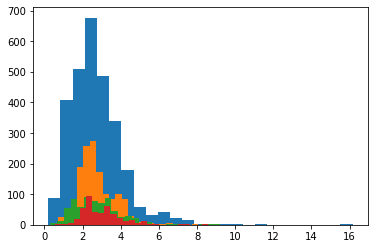

In [4]:

audio_image = image_loader(data_dir, folds_file,test_fold, True, "Params_json", input_transform=None, stetho_id=-1)

In [5]:
"""
in the testdataset :

=============== the normal information =======================
 the number of normal samples:
 775
  0 < Fraction of samples < 2 seconds:  0.37548387096774194

  2 < Fraction of samples < 3 seconds:  0.41419354838709677

  3 < Fraction of samples < 4 seconds:  0.1664516129032258

  4 < Fraction of samples  seconds:  0.04387096774193548

=============== the crackle information =======================
the number of crackle samples:
 391
  0 < Fraction of samples < 2 seconds:  0.1534526854219949

  2 < Fraction of samples < 3 seconds:  0.27621483375959077

  3 < Fraction of samples < 4 seconds:  0.4578005115089514

  4 < Fraction of samples  seconds:  0.11253196930946291


=============== the wheeze  information =======================
 the number of wheeze samples:
 206
  0 < Fraction of samples < 2 seconds:  0.28640776699029125

  2 < Fraction of samples < 3 seconds:  0.30097087378640774

  3 < Fraction of samples < 4 seconds:  0.32038834951456313

  4 < Fraction of samples  seconds:  0.09223300970873786


=============== the both  information =======================
 the number of both samples:
 72
  0 < Fraction of samples < 2 seconds:  0.1527777777777778

  2 < Fraction of samples < 3 seconds:  0.09722222222222222

  3 < Fraction of samples < 4 seconds:  0.4305555555555556

  4 < Fraction of samples  seconds:  0.3194444444444444






"""

'\nin the testdataset :\n\n=============== the normal information =======================\n the number of normal samples:\n 775\n  0 < Fraction of samples < 2 seconds:  0.37548387096774194\n\n  2 < Fraction of samples < 3 seconds:  0.41419354838709677\n\n  3 < Fraction of samples < 4 seconds:  0.1664516129032258\n\n  4 < Fraction of samples  seconds:  0.04387096774193548\n\n=============== the crackle information =======================\nthe number of crackle samples:\n 391\n  0 < Fraction of samples < 2 seconds:  0.1534526854219949\n\n  2 < Fraction of samples < 3 seconds:  0.27621483375959077\n\n  3 < Fraction of samples < 4 seconds:  0.4578005115089514\n\n  4 < Fraction of samples  seconds:  0.11253196930946291\n\n\n=============== the wheeze  information =======================\n the number of wheeze samples:\n 206\n  0 < Fraction of samples < 2 seconds:  0.28640776699029125\n\n  2 < Fraction of samples < 3 seconds:  0.30097087378640774\n\n  3 < Fraction of samples < 4 seconds:  0.